Tutorial 3: Non Linear Search
=============================

In the previous tutorials, we laid the groundwork by defining a model and manually fitting it to data using fitting
functions. We quantified the goodness of fit using the log likelihood and demonstrated that for models with only a few
free parameters, we could achieve satisfactory fits by manually guessing parameter values. However, as the complexity
of our models increased, this approach quickly became impractical.

In this tutorial, we will delve into a more systematic approach for fitting models to data. This technique is designed
to handle models with a larger number of parameters—ranging from tens to hundreds. By adopting this approach, we aim
to achieve more efficient and reliable model fits, ensuring that our models accurately capture the underlying
structure of the data.

This approach not only improves the accuracy of our fits but also allows us to explore more complex models that better
represent the systems we are studying.

__Overview__

In this tutorial, we will use a non-linear search to fit a 1D Gaussian profile to noisy data. Specifically, we will:

- Introduce concept like a "parameter space", "likelihood surface" and "priors", and relate them to how a non-linear
  search works.

- Introduce the `Analysis` class, which defines the `log_likelihood_function` that quantifies the goodness of fit of a
  model instance to the data.

- Fit a 1D Gaussian model to 1D data with a non-linear search, specifically with the nested sampling algorithm
  `Dynesty`.

All these steps utilize **PyAutoFit**'s API for model-fitting.

__Contents__

This tutorial is split into the following sections:

- **Parameter Space**: Introduce the concept of a "parameter space" and how it relates to model-fitting.
- **Non-Linear Search**: Introduce the concept of a "non-linear search" and how it fits models to data.
- **Nested Sampling**: Introduce the nested sampling method used in this tutorial.
- **Deeper Background**: Provide links to resources that more thoroughly describe the statistical principles that underpin non-linear searches.
- **Data**: Load and plot the 1D Gaussian dataset we'll fit.
- **Model**: Introduce the 1D `Gaussian` model we'll fit to the data.
- **Priors**: Introduce priors and how they are used to define the parameter space and guide the non-linear search.
- **Analysis**: Introduce the `Analysis` class, which contains the `log_likelihood_function` used to fit the model to the data.
- **Search**: Perform the model-fit using a non-linear search.
- **Result**: The result of the model-fit, including the maximum likelihood model.
- **Samples**: The samples of the non-linear search, used to compute parameter estimates and uncertainties.
- **Customizing Searches**: How to customize the settings of the non-linear search.
- **Wrap Up**: A summary of the concepts introduced in this tutorial.

__Parameter Space__

In mathematics, a function is defined by its parameters, which relate inputs to outputs.

For example, consider a simple function:

\[ f(x) = x^2 \]

Here, \( x \) is the parameter input into the function \( f \), and \( f(x) \) returns \( x^2 \). This
mapping between \( x \) and \( f(x) \) defines the "parameter space" of the function, which in this case is a parabola.

Functions can have multiple parameters, such as \( x \), \( y \), and \( z \):

\[ f(x, y, z) = x + y^2 - z^3 \]

Here, the mapping between \( x \), \( y \), \( z \), and \( f(x, y, z) \) defines a parameter space with three
dimensions.

This concept of a parameter space relates closely to how we define and use instances of models in model-fitting.
For instance, in our previous tutorial, we used instances of a 1D Gaussian profile with
parameters \( (x, I, \sigma) \) to fit data and compute a log likelihood. This process can be thought of as a
function \( f(x, I, \sigma) \), where the output value is the log likelihood.

By expressing the likelihood in this manner, we can consider our model as having a parameter space -— a
multidimensional surface that spans all possible values of the model parameters \( x, I, \sigma \).

This surface is often referred to as the "likelihood surface", and our objective during model-fitting is to find
its peak.

This parameter space is "non-linear", meaning the relationship between the input parameters and the log likelihood
does not behave linearly. This non-linearity implies that we cannot predict the log likelihood from a set of model
parameters without actually performing a fit to the data by performing the forward model calculation.

__Non-Linear Search__

Now that we understand our problem in terms of a non-linear parameter space with a likelihood surface, we can
introduce the method used to fit the model to the data—the "non-linear search".

Previously, our approach involved manually guessing models until finding one with a good fit and high log likelihood.
Surprisingly, this random guessing forms the basis of how model-fitting using a non-linear search actually works!

A non-linear search involves systematically guessing many models while tracking their log likelihoods. As the
algorithm progresses, it tends to favor models with parameter combinations that have previously yielded higher
log likelihoods. This iterative refinement helps to efficiently explore the vast parameter space.

There are two key differences between guessing random models and using a non-linear search:

- **Computational Efficiency**: The non-linear search can evaluate the log likelihood of a model parameter
  combinations in milliseconds and therefore many thousands of models in minutes. This computational speed enables
  it to thoroughly sample potential solutions, which would be impractical for a human.

- **Effective Sampling**: The search algorithm maintains a robust memory of previously guessed models and their log
  likelihoods. This memory allows it to sample potential solutions more thoroughly and converge on the highest
  likelihood solutions more efficiently, which is again impractical for a human.

Think of the non-linear search as systematically exploring parameter space to pinpoint regions with the highest log
likelihood values. Its primary goal is to identify and converge on the parameter values that best describe the data.

__Nested Sampling__

There are various non-linear search algorithms, each exploring parameter space differently. This tutorial utilizes a
Nested Sampling method called `Dynesty` (https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2016/NestedSampling_JRP.pdf

For now, we won't delve into the specifics of how nested samlping methods work; instead, we'll stick with the simplified
overview provided above.

__Deeper Background__

This very simplified explanation of how a non-linear search works overlooks many of the underlying statistical
principles that ensure robust results and enable it to sample parameter space effectively.

The focus of the HowToFit lectures are to give you a phenomenological understanding how to fit a model to data,
rather than delving into the intricacies of Bayesian inference and statistical sampling.

If you're interested in learning more about these principles, you can explore resources such as:

- [Nested Sampling](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2016/NestedSampling_JRP.pdf)
- [Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)
- [Introduction to MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)
- [A Zero-Math Introduction to MCMC Methods](https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50)

In [1]:
import autofit.plot as aplt
import numpy as np
import matplotlib.pyplot as plt
from os import path

import autofit as af

%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2`


__Data__

Load and plot the dataset from the `autofit_workspace/dataset` folder.

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


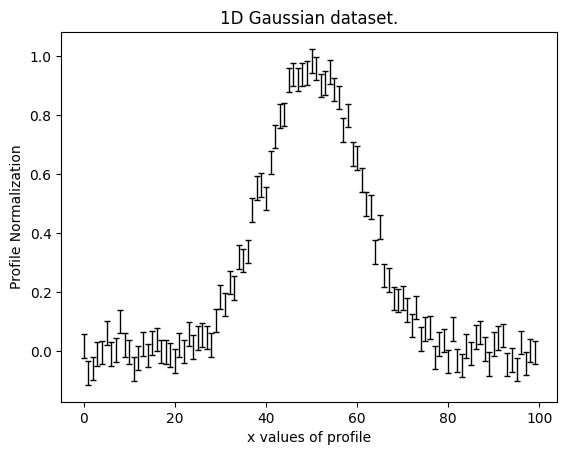

<Figure size 640x480 with 0 Axes>

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

xvalues = np.arange(data.shape[0])

plt.errorbar(
    xvalues,
    data,
    yerr=noise_map,
    linestyle="",
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()
plt.clf()

__Model__

Create the `Gaussian` class from which we will compose model components using the standard format.

In [3]:


class Gaussian:
    def __init__(
        self,
        centre: float = 30.0,  # <- **PyAutoFit** recognises these constructor arguments
        normalization: float = 1.0,  # <- are the Gaussian`s model parameters.
        sigma: float = 5.0,
    ):
        """
        Represents a 1D Gaussian profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to perform model-fitting
        of example datasets.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        sigma
            The sigma value controlling the size of the Gaussian.
        """
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def model_data_from(self, xvalues: np.ndarray) -> np.ndarray:
        """
        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.

        Returns
        -------
        np.array
            The Gaussian values at the input x coordinates.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


We now compose our model, a single 1D Gaussian, which we will fit to the data via the non-linear search.

In [4]:
model = af.Model(Gaussian)

print(model.info)

Total Free Parameters = 3

model                                                                           Gaussian (N=3)

centre                                                                          UniformPrior [0], lower_limit = 0.0, upper_limit = 100.0
normalization                                                                   LogUniformPrior [1], lower_limit = 1e-06, upper_limit = 1000000.0
sigma                                                                           UniformPrior [2], lower_limit = 0.0, upper_limit = 25.0


__Priors__

When we examine the `.info` of our model, we notice that each parameter (like `centre`, `normalization`, 
and `sigma` in our Gaussian model) is associated with priors, such as `UniformPrior`. These priors define the 
range of permissible values that each parameter can assume during the model fitting process.

For instance, consider the `centre` parameter of our Gaussian. In theory, it could take on any value from 
negative to positive infinity. However, upon inspecting our dataset, we observe that valid values for `centre` 
fall strictly between 0.0 and 100.0. By using a `UniformPrior` with `lower_limit=0.0` and `upper_limit=100.0`, 
we restrict our parameter space to include only physically plausible values.

Priors serve two primary purposes:

**Defining Valid Parameter Space:** Priors specify the range of parameter values that constitute valid solutions. 
This ensures that our model explores only those solutions that are consistent with our observed data and physical 
constraints.

**Incorporating Prior Knowledge:** Priors also encapsulate our prior beliefs or expectations about the model 
parameters. For instance, if we have previously fitted a similar model to another dataset and obtained certain 
parameter values, we can incorporate this knowledge into our priors for a new dataset. This approach guides the 
model fitting process towards parameter values that are more probable based on our prior understanding.

While we are using `UniformPriors` in this tutorial due to their simplicity, **PyAutoFit** offers various other 
priors like `GaussianPrior` and `LogUniformPrior`. These priors are useful for encoding different forms of prior 
information, such as normally distributed values around a mean (`GaussianPrior`) or parameters spanning multiple 
orders of magnitude (`LogUniformPrior`).

In [5]:
model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.normalization = af.UniformPrior(lower_limit=0.0, upper_limit=10.0)
model.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=10.0)

__Analysis__

In **PyAutoFit**, the `Analysis` class plays a crucial role in interfacing between the data being fitted and the 
model under consideration. Its primary responsibilities include:

**Receiving Data:** The `Analysis` class is initialized with the data (`data`) and noise map (`noise_map`) that 
 the model aims to fit. 

**Defining the Log Likelihood Function:** The `Analysis` class defines the `log_likelihood_function`, which 
 computes the log likelihood of a model instance given the data. It evaluates how well the model, for a given set of 
 parameters, fits the observed data. 

**Interface with Non-linear Search:** The `log_likelihood_function` is repeatedly called by the non-linear search 
 algorithm to assess the goodness of fit of different parameter combinations. The search algorithm call this function
 many times and maps out regions of parameter space that yield high likelihood solutions.
    
Below is a suitable `Analysis` class for fitting a 1D gaussian to the data loaded above.

In [6]:


class Analysis(af.Analysis):
    def __init__(self, data: np.ndarray, noise_map: np.ndarray):
        """
        The `Analysis` class acts as an interface between the data and model in **PyAutoFit**.

        Its `log_likelihood_function` defines how the model is fitted to the data and it is called many times by
        the non-linear search fitting algorithm.

        In this example the `Analysis` `__init__` constructor only contains the `data` and `noise-map`, but it can be
        easily extended to include other quantities.

        Parameters
        ----------
        data
            A 1D numpy array containing the data (e.g. a noisy 1D signal) fitted in the workspace examples.
        noise_map
            A 1D numpy array containing the noise values of the data, used for computing the goodness of fit
            metric, the log likelihood.
        """
        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance) -> float:
        """
        Returns the log likelihood of a fit of a 1D Gaussian to the dataset.

        The `instance` that comes into this method is an instance of the `Gaussian` model above. The parameter values
        are chosen by the non-linear search, based on where it thinks the high likelihood regions of parameter
        space are.

        The lines of Python code are commented out below to prevent excessive print statements when we run the
        non-linear search, but feel free to uncomment them and run the search to see the parameters of every instance
        that it fits.

        print("Gaussian Instance:")
        print("Centre = ", instance.centre)
        print("Normalization = ", instance.normalization)
        print("Sigma = ", instance.sigma)

        The data is fitted using an `instance` of the `Gaussian` class where its `model_data_from`
        is called in order to create a model data representation of the Gaussian that is fitted to the data.
        """
        xvalues = np.arange(self.data.shape[0])

        model_data = instance.model_data_from(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        chi_squared = sum(chi_squared_map)
        noise_normalization = np.sum(np.log(2 * np.pi * noise_map**2.0))
        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood


We create an instance of the `Analysis` class by simply passing it the `data` and `noise_map`:

In [7]:
analysis = Analysis(data=data, noise_map=noise_map)

__Search__

To use the non-linear search `Dynesty` we simply create an instance of the `af.DynestyStatic` object. The word
static refers to us using the static variant of the Dynesty algorithm, rather than the dynamic variant. You don't
need to worry about this for now.

No inputs are specified for the `Dynesty` object, even though it (and all non-linear searches) have many tunable
parameters that control the behaviour of the non-linear search. The next tutorials describes how a search's settings
can change the behaviour of the non-linear search and your results.

The default settings of the non-linear search are specified in **PyAutoFit** configuration files found in the
`autofit_workspace/config/non_linear` folder. 

For now, we use the default configuration settings, which are sufficient for simple model fitting problems. In 
chapter 2, we will consider how and when these settings should be manually specified for your model fitting problem.

In this example, non-linear search results are stored in memory rather and not written to hard disk because the fits 
are fast and can therefore be easily regenerated. The next tutorial will perform fits which write results to the
hard-disk.

In [8]:
search = af.DynestyStatic(
    sample="rwalk",  # This makes dynesty run faster, dont worry about what it means for now!
)

To begin the model-fit via the non-linear search, we pass it our model and analysis and begin the fit.

The fit will take a minute or so to run.

In [9]:
print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

model = af.Model(Gaussian)

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-07-16 13:58:59,488 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-07-16 13:58:59,490 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-07-16 13:58:59,490 - root - INFO - Starting new Dynesty non-linear search (no previous samples found).
2024-07-16 13:58:59,549 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-07-16 13:58:59,562 - process 0 - INFO - created
2024-07-16 13:58:59,597 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-07-16 13:58:59,678 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search


1006it [00:04, 205.26it/s, +50 | bound: 106 | nc: 1 | ncall: 5985 | eff(%): 17.793 | loglstar:   -inf < 184.768 <    inf | logz: 167.400 +/-  0.509 | dlogz:  0.001 >  0.059]


2024-07-16 13:59:04,924 - root - INFO - Search complete, returning result
The search has finished run - you may now continue the notebook.


__Result__

Upon completion the non-linear search returns a `Result` object, which contains information about the model-fit.

The `info` attribute shows the result in a readable format.

[Above, we discussed that the `info_whitespace_length` parameter in the config files could b changed to make 
the `model.info` attribute display optimally on your computer. This attribute also controls the whitespace of the
`result.info` attribute.]

In [10]:
print(result.info)

Bayesian Evidence                                                               167.39957341
Maximum Log Likelihood                                                          184.76824269
Maximum Log Posterior                                                           881490.59813366

model                                                                           Gaussian (N=3)

Maximum Log Likelihood Model:

centre                                                                          50.213
normalization                                                                   25.263
sigma                                                                           10.300


Summary (3.0 sigma limits):

centre                                                                          50.25 (49.76, 50.55)
normalization                                                                   25.32 (24.49, 26.18)
sigma                                                                           10.31 (9.91, 10.

The result has a "maximum log likelihood instance", which refers to the specific set of model parameters (e.g., 
for a `Gaussian`) that yielded the highest log likelihood among all models tested by the non-linear search.

In [11]:
print("Maximum Likelihood Model:\n")
max_log_likelihood_instance = result.samples.max_log_likelihood()
print("Centre = ", max_log_likelihood_instance.centre)
print("Normalization = ", max_log_likelihood_instance.normalization)
print("Sigma = ", max_log_likelihood_instance.sigma)

Maximum Likelihood Model:

Centre =  50.21305690969757
Normalization =  25.263372786925643
Sigma =  10.29961438881635


We can use this to plot the maximum log likelihood fit over the data and confirm that a good fit was inferred:

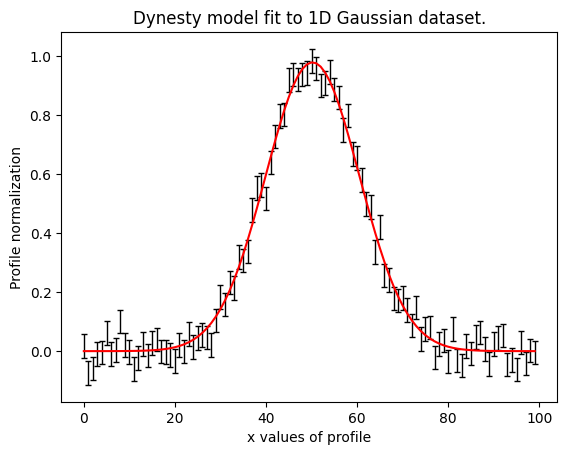

In [12]:
model_data = result.max_log_likelihood_instance.model_data_from(
    xvalues=np.arange(data.shape[0])
)
plt.errorbar(
    x=xvalues,
    y=data,
    yerr=noise_map,
    linestyle="",
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.plot(xvalues, model_data, color="r")
plt.title("Dynesty model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.show()
plt.close()

__Samples__

Above, we used the `Result`'s `samples` property, which in this case is a `SamplesNest` object:

In [13]:
print(result.samples)

SamplesNest(1056)


This object acts as an interface between the `Dynesty` output results and your Jupyter Notebook or Python code. 

For example, we can use it to get the parameters and log likelihood of an accepted Dynesty sample.

In [14]:
print(result.samples.parameter_lists[10][:])
print(result.samples.log_likelihood_list[10])

[99.9695652006751, 15273.278057293493, 8.54436116790023]
-1128759247.7080317


You can visualize the "Probability Density Functions (PDFs)" of the results using a software package called 
`anesthetic` through the `NestPlotter` object in Dynesty. 

These plots display the 1D and 2D probabilities estimated for each parameter after fitting the model. The 2D 
figures reveal parameter degeneracies, such as how changes in one parameter (like increasing \(\sigma\) while 
decreasing normalization \(I\)) can result in similar likelihoods and probabilities.

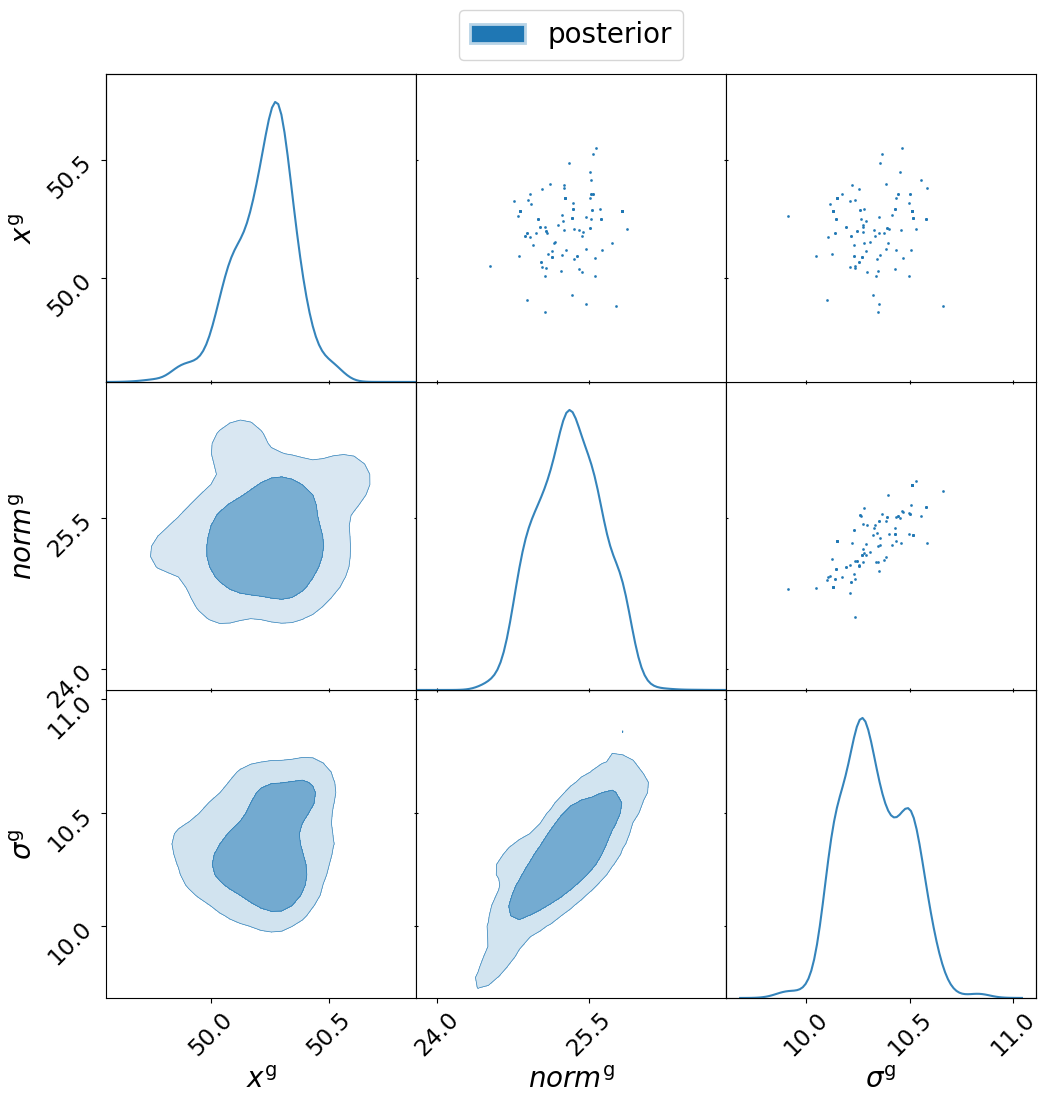

In [15]:
plotter = aplt.NestPlotter(samples=result.samples)
plotter.corner_anesthetic()

A more detailed description of the `Result` object is given in tutorial 5 of this chapter.

__Wrap Up__

This tutorial has laid the foundation with several fundamental concepts in model fitting and statistical inference:

1. **Parameter Space**: This refers to the range of possible values that each parameter in a model can take. It 
defines the dimensions over which the likelihood of different parameter values is evaluated.

2. **Likelihood Surface**: This surface represents how the likelihood of the model varies across the parameter space. 
It helps in identifying the best-fit parameters that maximize the likelihood of the model given the data.

3. **Non-linear Search**: This is an optimization technique used to explore the parameter space and find the 
combination of parameter values that best describe the data. It iteratively adjusts the parameters to maximize the likelihood.

4. **Priors**: Priors are probabilities assigned to different values of parameters before considering the data. 
They encapsulate our prior knowledge or assumptions about the parameter values. Priors can constrain the parameter 
space, making the search more efficient and realistic.

5. **Model Fitting**: The process of adjusting model parameters to minimize the difference between model predictions 
and observed data, quantified by the likelihood function.

Understanding these concepts is crucial as they form the backbone of model fitting and parameter estimation in 
scientific research and data analysis. In the next tutorials, these concepts will be further expanded upon to 
deepen your understanding and provide more advanced techniques for model fitting and analysis.